# Setup

In [1]:
import os
import torch
import pytz
import numpy as np

from tqdm import tqdm
from datetime import datetime

from plotting.PlotPathsAlanine import PlotPathsAlanine
from policies.Alanine import NNPolicy

from openmm import app
import openmm as mm
import openmm.unit as unit
from openmmtools.integrators import VVVRIntegrator

from potentials.md_utils import ForceReporter

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
kst = pytz.timezone('Asia/Seoul')
# current_date = datetime.now(kst).strftime("%m%d-%H%M%S")
current_date = "0511-161723"

In [3]:
# Setup environment
device = 'cuda:1'

# Experimental setup
T = 500.  # Time horizon
n_rollouts = 10 #15000 # Number of epochs
n_samples = 16 # Number of trajectories for each epoch
std = 0.1
lr = 0.0001

# Some specifics about the molecule
u_dim = 22 * 3 # Doesn't include the positions
dim = u_dim * 2 # Full dimension of the statespace

# Derived values
dt = torch.tensor(1.)
n_steps = int(T / dt)

# Molecular configuration

In [4]:
class AlanineOpenMM():
    def __init__(self, start_file, device, overide=True, index=0):
        """
        Intialize the OpenMM configuration
        """
        self.index = index
        self.start_file = start_file
        self.device = device

        # Setup openMM
        self.forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
        self.pdb = app.PDBFile(self.start_file)
        self.system = self.forcefield.createSystem(
            self.pdb.topology,
            nonbondedMethod=app.PME,
            nonbondedCutoff=1.0 * unit.nanometers,
            constraints=app.HBonds,
            ewaldErrorTolerance=0.0005
        )

        # Implement external force
        self.external_force = mm.CustomExternalForce("k*(fx*x + fy*y + fz*z)")

        # creating the parameters
        self.external_force.addGlobalParameter("k", 1000)
        self.external_force.addPerParticleParameter("fx")
        self.external_force.addPerParticleParameter("fy")
        self.external_force.addPerParticleParameter("fz")
        self.system.addForce(self.external_force)
        for i in range(len(self.pdb.positions)):
            self.external_force.addParticle(i, [0, 0, 0])

        # Setup integrator
        self.integrator = VVVRIntegrator(
            300 * unit.kelvin,  # temp
            1.0 / unit.picoseconds,  # collision rate
            1.0 * unit.femtoseconds)  # timestep
        self.integrator.setConstraintTolerance(0.00001)

        # Environment setup
        self.platform = mm.Platform.getPlatformByName('CUDA')
        self.properties = {'DeviceIndex': '0', 'Precision': 'mixed'}

        # Finalize simulation
        self.simulation = app.Simulation(self.pdb.topology, self.system, self.integrator,
                                    self.platform, self.properties)
        self.simulation.context.setPositions(self.pdb.positions)
        
        self.simulation.step(1)
        self.simulation.minimizeEnergy()
        
        if overide:
            if not os.path.exists(f"./results/notebook/{current_date}"):
                os.makedirs(f"./results/notebook/{current_date}")
            self.simulation.saveCheckpoint(f"./results/notebook/{current_date}/simulation_save_{self.index}")
            

    def get_closest_minima(self):
        """
        Given the current state of the system (atom locations) the closes local minima in the Potential Energy surface is returned
        """
        self.simulation.step(1)
        self.simulation.minimizeEnergy()
        self.simulation.step(1)

        return self.get_current_positions()


    def perform_OpenMM_step(self, control=None):
        """
        Performs the OpenMM step based on the given control. This is achieved by setting the placeholder values. 
        """
        if control is not None:
            for i in range(control.shape[0]):
                self.external_force.setParticleParameters(i, i, control[i])
            self.external_force.updateParametersInContext(self.simulation.context)

        self.simulation.step(1)

        return self.get_current_positions()
    
    
    def get_current_positions(self):
        """
        Helper function to get the current positions of the atoms.
        """
        positions = self.simulation.context.getState(True).getPositions(True).value_in_unit(unit.nanometer)
        positions = torch.asarray(positions, dtype=torch.float, device=device)

        return positions


    def reset(self):
        """
        Resets the atoms to the initial positions and removes the current bias potential. 
        The minimizeEnergy() call cancels out the velocities. 
        """
        self.simulation.loadCheckpoint(f"./results/notebook/{current_date}/simulation_save_{self.index}")
        for i in range(len(self.pdb.positions)):
            self.external_force.setParticleParameters(i, i, [0, 0, 0])
        self.external_force.updateParametersInContext(self.simulation.context)
        

In [5]:
# Initialize the different OpenMM implemenations
MDs = []
for i in tqdm(range(0, n_samples)):
    pot = AlanineOpenMM('./potentials/files/AD_c7eq.pdb', device, index=i)
    MDs.append(pot)

 69%|██████▉   | 11/16 [00:29<00:13,  2.68s/it]

In [ ]:
def get_starting_positions(MDs):
    initial_positions = []
    for MD in MDs:
        initial_positions.append(MD.get_current_positions())

    initial_positions = torch.stack(initial_positions).view(len(MDs), -1)

    return initial_positions


def run_simulations(MDs, control):
    positions = []
    for idx, MD in enumerate(MDs):
        positions.append(MD.perform_OpenMM_step(control[idx].view(-1, 3)))

    positions = torch.stack(positions).view(len(MDs), -1)

    return positions

def reset(MDs):
    for MD in MDs:
        MD.reset()
        
def phi(x, end):
    x = x[:, -1, :].view(x.shape[0], -1, 3)

    px = torch.cdist(x, x)
    pend = torch.cdist(end, end).repeat(x.shape[0], 1, 1)

    t = (px - pend) ** 2
    cost_distance = torch.mean(t, dim=(1, 2))
    cost_distance_final = (cost_distance).exp() - 1.

    return cost_distance_final * 100, t


In [ ]:
# Retrieve the target state
endMD = AlanineOpenMM('./potentials/files/AD_c7ax.pdb', device, overide=False)
ending_positions = endMD.get_closest_minima()

# Sampling

In [ ]:
policy = torch.load("./policies/policy_2806", map_location=device)
# policy = torch.load("./configs/alanine/path_policy", map_location=device)

policy.vel_given = False
paths = torch.zeros((n_samples, n_steps+1, u_dim), device=device)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:26<00:00, 18.58it/s]


AttributeError: 'NoneType' object has no attribute 'remove'

<Figure size 640x480 with 0 Axes>

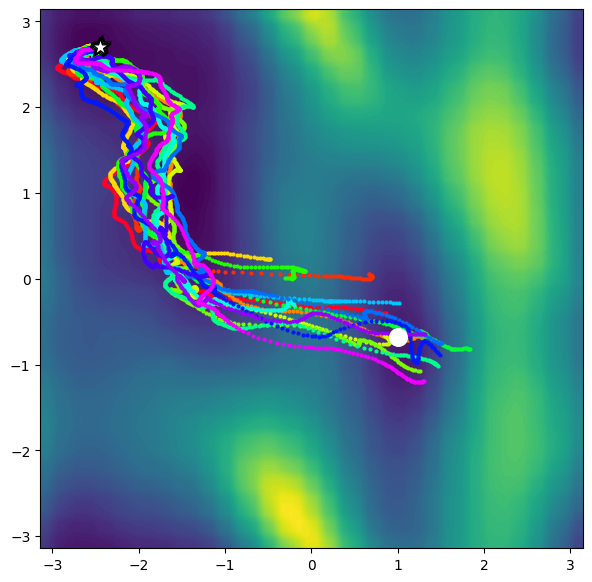

In [ ]:
reset(MDs)

# Initialize start positions of path
paths[:, 0, :] = get_starting_positions(MDs)
new_state = paths[:, 0, :].to(device)

for s in tqdm(range(0, n_steps)):
    x = new_state.detach()
    # t = torch.tensor(s * dt)
    t = (s * dt).clone().detach()

    # Sample control and noise
    update_u = policy(x, t)
    update_action = update_u * dt

    # Perform OpenMM step
    positions = run_simulations(MDs, update_action)
    new_state = positions.to(device)

    # Bookkeeping
    paths[:, s+1, :]  = new_state

# Reset the MD simulations
reset(MDs)

# Print results
phi_cost, t = phi(paths, ending_positions)
order = phi_cost.argsort()
colors = PlotPathsAlanine(paths, ending_positions)